# Batch Time and Real-time Prediction

In [14]:
# Importing the necessary library
import boto3
import sagemaker
import pandas as pd
from joblib import dump, load
import s3fs

In [15]:
# Initialising new sagemaker session as "sess".
sess = sagemaker.Session()
# Bucket variable is used for storing the location of the bucket
bucket = 'sagemaker-studio-009676737623-l4vs7j0o0ib'
# Assigning the prefix variable
prefix = 'mlops-level1-data'
# Check for necessary permission needed for training and deploying models. 
role = sagemaker.get_execution_role()
# To understand where this session is configured to operate.
region = boto3.Session().region_name

## Test Data

In [3]:
# Creating a string for the test path 
test_data_path = f's3://{bucket}/{prefix}/test_data.csv'

In [4]:
# Importing the dataset
test_data = pd.read_csv(test_data_path)
test_data.shape

(610, 562)

In [5]:
# Treating missing values
test_data.isna().sum()
test_data.dropna(inplace = True)
test_data.shape

(609, 562)

In [6]:
## Get Features
fs = s3fs.S3FileSystem() # Updated method name
filename = f's3://{bucket}/{prefix}/feature/feature.joblib'
with fs.open(filename, encoding='utf8') as fh:
    cols = load(fh)

## Get Encoder object
filename = f's3://{bucket}/{prefix}/feature/encoder.joblib'
with fs.open(filename, encoding='utf8') as fh:
    encoder = load(fh)

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LabelEncoder from version 0.23.2 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [7]:
cols

array(['tGravityAcc-energy()-X', 'tGravityAcc-mean()-X',
       'tGravityAcc-min()-Y', 'tGravityAcc-max()-Y',
       'tGravityAcc-mean()-Y', 'tGravityAcc-min()-X',
       'angle(X,gravityMean)', 'tGravityAcc-max()-X',
       'angle(Y,gravityMean)', 'tGravityAccMag-std()',
       'tBodyAccJerk-entropy()-X', 'tBodyAcc-max()-X', 'Activity'],
      dtype=object)

In [8]:
processed_test_data = test_data[cols]
test_x = processed_test_data.drop('Activity', axis = 1)
test_y= processed_test_data[['Activity']]
test_x.shape, test_y.shape


((609, 12), (609, 1))

## Save Processed Test to S3

In [9]:
test_x_path = f"s3://{bucket}/{prefix}/prediction/test/test_x.csv"
test_y_path =f"s3://{bucket}/{prefix}/prediction/test/test_y.csv"
test_x.to_csv(test_x_path, index=False, header=False)
test_y.to_csv(test_y_path, index=False, header=False)


## Batch Model Prediction

In [16]:
final_model = 'HumanActivity-InferenceEndpoint-final-2023-09-24-1232' ## Update Inference Endpoint


In [17]:
from sagemaker.transformer import Transformer
transformer_output_path = f"s3://{bucket}/{prefix}/transformer-output"

sklearn_transformer = Transformer(
    model_name=final_model,
    instance_count=1,
    instance_type='ml.m5.large', 
    output_path=transformer_output_path
)

sklearn_transformer.transform(
    data=test_x_path,
    data_type='S3Prefix',
    content_type='text/csv'
)

ValueError: Failed to fetch model information for HumanActivity-InferenceEndpoint-final-2023-09-24-1232. Please ensure that the model exists. Local instance types require locally created models.

In [75]:
# cell 19
!aws s3 cp $transformer_output_path/test_x.csv.out ./predictions.csv


download: s3://sagemaker-studio-009676737623-l4vs7j0o0ib/mlops-level1-data/transformer-output/test_x.csv.out to ./predictions.csv


In [76]:
with open('./predictions.csv', 'r') as r:
    a = r.read()
prediction = [int(x) for x in a[1:-1].split(',')]
prediction_df = pd.DataFrame({'prediction':prediction})


In [77]:
prediction_df['label']= encoder.inverse_transform(prediction_df)


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [78]:
prediction_df['label'].value_counts()


label
STANDING              169
WALKING               144
LAYING                111
SITTING                90
WALKING_UPSTAIRS       78
WALKING_DOWNSTAIRS     17
Name: count, dtype: int64

Text(0, 0.5, 'Activity Count')

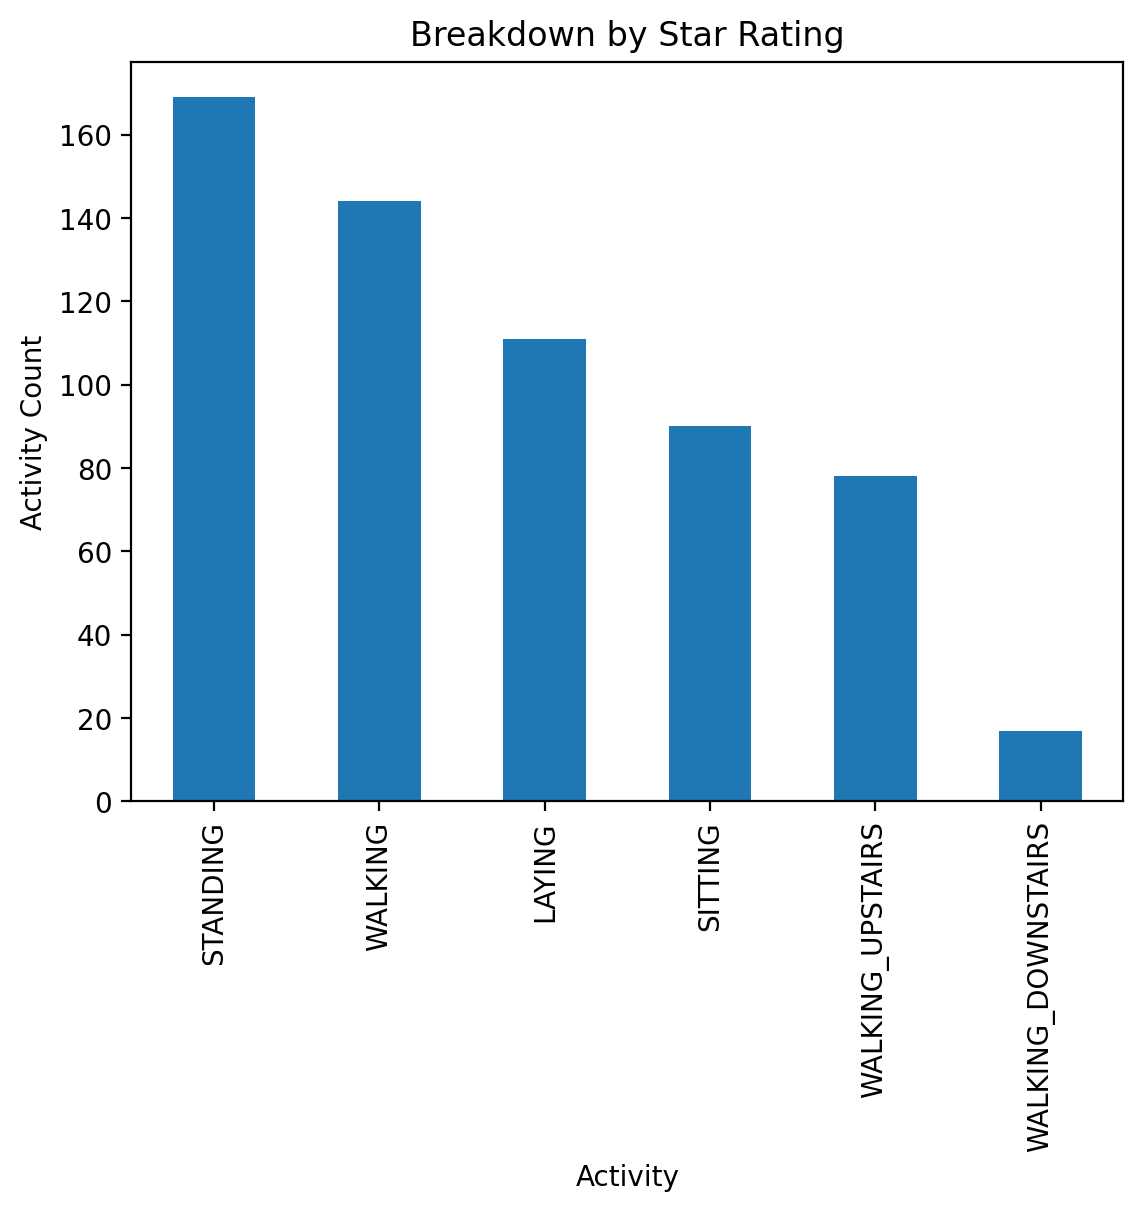

In [82]:
# Visualising the data distribution of the predicted activity column
import matplotlib.pyplot as plt
prediction_df['label'].value_counts().plot(kind="bar", title="Batch prediction")
plt.xlabel("Activity")
plt.ylabel("Activity Count")

### Prediction Evaluation

In [81]:
from sklearn.metrics import classification_report
print(classification_report(test_y['Activity'].values,  prediction_df['label']))


                    precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       111
           SITTING       1.00      0.91      0.95        99
          STANDING       0.67      1.00      0.81       114
           WALKING       0.65      0.74      0.69       126
WALKING_DOWNSTAIRS       1.00      0.24      0.38        72
  WALKING_UPSTAIRS       0.62      0.55      0.58        87

          accuracy                           0.78       609
         macro avg       0.82      0.74      0.74       609
      weighted avg       0.81      0.78      0.76       609



# Real time Prediction

In [81]:
def real_time_prediction(data,ENDPOINT_NAME):
    runtime= boto3.client('runtime.sagemaker')
    df = data.copy()
    n = df.shape[0]
    if n == 1:
        df = pd.concat([df,df])
    payload_data = df.to_csv(header=False, index=False).encode("utf-8")
    print(df.shape)
    response = runtime.invoke_endpoint(EndpointName=ENDPOINT_NAME,
                                      ContentType='text/csv',
                                      Body=payload_data)
    result = json.loads(response['Body'].read().decode())
    preds = {"Prediction": result}
    if n == 1:
        preds = {'Prediction': preds['Prediction'][0]}
    response_dict = {
          "statusCode": 200,
          "body": json.dumps(preds)
                }
    return response_dict

In [84]:
real_time_prediction(test_x.iloc[0:10], 'rf-scikit-2023-09-19-06-34-16-121')

(10, 12)


{'statusCode': 200, 'body': '{"Prediction": [2, 2, 2, 1, 2, 2, 2, 2, 2, 2]}'}

In [58]:
client = boto3.client('sagemaker-runtime')

In [55]:
endpoint_name = 'HumanActivity-InferenceEndpoint-final-2023-09-24-1232'

In [93]:
from sagemaker.predictor import Predictor
from sagemaker.serializers import CSVSerializer, JSONSerializer
from sagemaker.deserializers import CSVDeserializer , JSONDeserializer

predictor_csv = Predictor(endpoint_name=endpoint_name,
                      serializer=CSVSerializer(),
                     deserializer=CSVDeserializer())

In [94]:
prediction = predictor_csv.predict(test_x.sample(100))

In [105]:
data_capture = 's3://sagemaker-studio-009676737623-l4vs7j0o0ib/mlops-level1-data/datacapture/HumanActivity-InferenceEndpoint-final-2023-09-24-1232/AllTraffic/2023/09/24/17/19-51-197-85b5945f-2161-44ba-b0a9-5888de4fb654.jsonl'

In [106]:
json_df = pd.read_json(data_capture,lines=True)

In [107]:
json_df

,captureData,eventMetadata,eventVersion
0,{'endpointInput': {'observedContentType': 'tex...,{'eventId': '051fdb3c-a274-4b3f-b3f6-efa3228b2...,0


In [126]:
input_data = json_df['captureData'][0]['endpointInput']['data']

In [136]:
output_data = input_data.replace("\n",'","')

In [137]:
output_data

'0.71769343,0.89284081,-0.37339565,-0.38395603,-0.38445152,0.89714403,-0.61481141,0.82788708,0.34778005,-0.26406953,0.55353237,-0.20506262","-0.90294148,-0.16876892,0.89378867,0.88001315,0.91490323,-0.25035687,0.36427666,-0.079814823,-0.8048647,0.022248669,-0.035489337,-0.91333655","0.9078289,0.96656113,-0.11489334,-0.16134256,-0.14155127,0.98452014,-0.8447876,0.89206031,0.18028889,-0.97605707,-0.8750964,-0.94306751","-0.83176745,-0.0467126879999999,0.81005646,0.74729201,0.7954083000000001,-0.0063605256,0.27705205,-0.11604333,-0.5781225,-0.99684745,-0.77431943,-0.93606548","0.89946864,0.96339614,-0.12321341,-0.16126549,-0.14083968,0.97743631,-0.84124676,0.89205451,0.17994061,-0.9505515,-0.81994925,-0.93472378","0.66848961,0.8731213,-0.37146773,-0.40507089,-0.39366157,0.87952385,-0.61186062,0.80423112,0.35803868,-0.32439212,0.64509465,-0.28933765","0.77250946,0.91447109,-0.29856637,-0.32447691,-0.31989706,0.91986778,-0.69838906,0.8587444,0.30487801,-0.40943463,0.65285338,-0.23294709","0

In [122]:
data = output_data + "," + input_data